In [2]:
from collections import defaultdict
from sklearn import linear_model
import gzip
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# SECTION 1
## Task Identification

We aim to make predictions about Steam game bundles. Steam is a platform where users can buy video games online. Sometimes, multiple games are offered as part of a "bundle" where the games are all discounted but you have to buy them together.

Our basic question is: 
> Can we predict which bundles a user will buy? 

More specifically, for any user, given two bundles, one which they bought and one which they didn't, can we correctly identify the one that they bought?

In particular, we aim to use a latent factor model in which we find a low dimensional representation of both a the user and the bundles, which we can use to predict how "compatible" each bundle is with the user. We can then simply take the more compatible bundle to be the one they purchased.

We can evaluate our model with a simple accuracy function. Given a bunch of triplets (user, bought-bundle, non-bought-bundle), for what proportion of triplets was the bought-bundle correctly identified?

For a baseline, we can compare this to an item-feature-based model. In this case, we think of each bundle being composed of multiple items. So instead of using latent factor based model, we can devise some model based on the literal features (like genre, tag, reviews, etc) of the games that are in the bundle. 

Due to the nature of our model, the accuracy function will suffice for assessing the validity. Since this isn't a regression problem, we don't necessarily expect the compatibility numbers to be directly interpretable. The only thing we really care about is the relative compatibility, i.e. is the bundle that was actually purchased by that user found to be more compatible than the one that wasn't? 

# SECTION 2
## Exploratory Analysis and Preprocessing

The data for this project comes from the datasets that the professor linked [here](https://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data). In particular, we mostly used the processed data that is linked on the [github](https://github.com/technoapurva/Steam-Bundle-Recommendation/tree/master) for the [this paper](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir17.pdf).



Here's a description of the major pre-cleaned datasets (from the github) that we used:

* `bundle_item_map.txt` - A dictionary with bundles as the keys and a set of items (games) in that bundle as the values
* `item_id_lookup.txt` - A dictionary that converts items to their IDs. Not conceptually important.
* `user_id_lookup.txt` - Same as the item id lookup. It's easier to encode usernames as integers from 0 to (total number of users) instead of strings. Not conceptually important.
* `user_item_map.txt` - A dictionary of games owned by each user
* `item_set.txt` - A set containing all the games
* `user_bundle_map.txt` - A dictionary containing all the bundles owned by each user

Some of these maps were also useful to keep an inverse map of.

In [3]:
user_bundle_map = pickle.load(open('dataset/user_bundle_map.txt','rb'))
user_id_lookup = pickle.load(open('dataset/user_id_lookup.txt','rb'))
id_user_lookup = {}
for k, v in user_id_lookup.items():
    id_user_lookup[v] = k
bundle_item_map = pickle.load(open('dataset/bundle_item_map.txt','rb'))
item_id_lookup = pickle.load(open('dataset/item_id_lookup.txt','rb'))
id_item_lookup = {}
for k, v in item_id_lookup.items():
    id_item_lookup[v] = k
user_item_map = pickle.load(open('dataset/user_item_map.txt','rb'))
item_set = pickle.load(open('dataset/item_set.txt','rb'))

A large piece of preprocessing we did is to turn the user bundle map into a usable dataset for machine learning. The problem is that there's no record of which bundles a player *doesn't* own. Thus for each (user, bought-bundle) in our dataset, we had to also find a bundle they didn't buy and attach that to the tuple manually. We did a similar thing in one of the homeworks, where we constructed a dataset of books that certain users hadn't read. However, the naive approach used in that homework doesn't lend itself to robust machine learning research. The problem is that, if you uniformly sample the bundles that a person hasn't purchased, you'll tend to pick up the less popular bundles. This is because a small number of bundles make up most of the purchases, as you can see here:

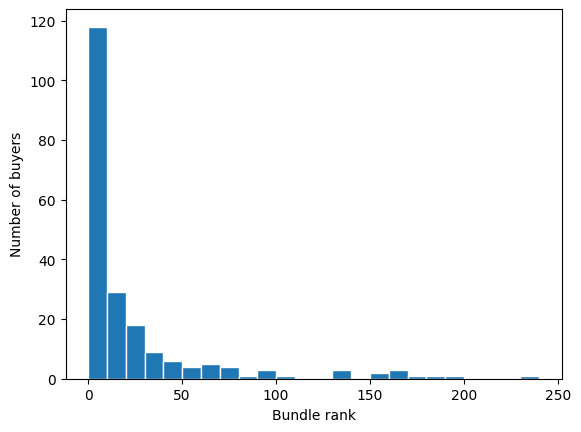

In [21]:
bundle_counts = defaultdict(int)
for user in user_bundle_map.keys():
    for bundle in user_bundle_map[user]:
        bundle_counts[bundle] += 1

plt.hist(bundle_counts.values(), bins = np.arange(0, 250, 10), ec = "w")
plt.xlabel("Bundle rank")
plt.ylabel("Number of buyers")
pass

This means that, instead of naively sampling uniformly amongst non-purchased bundles for each person, we had to construct a probability distribution over the bundles. By doing this, we can guarantee that more popular bundles are more likely to show up as negative examples. 

The general process was as follows:
1. Pick a user
2. Find all the bundles they *didn't* purchase
3. For each of those bundles, find the proportion of total bundle purchases they make up NOT counting the bundles purchased by this user. Here's an example: Let's say there are 3 bundles: bundle 0 with 100 purchases, bundle 1 with 50 purchases, and bundle 2 with 25 purchases. If user 0 purchased bundle 0 but not the other two, then bundle 1 would be twice as likely to get picked as the negative bundle than bundle 2.
4. Sample this probability distribution once.
5. Repeat for every (user, bought-bundle) pair in the data.

The code to do this took a while to run, so we stored the results, which we access here:

In [22]:
D_item = pd.read_csv("D_item.csv")
D_bundle = pd.read_csv("D_bundle.csv")

In [23]:
D_item.head(5)

,user,item_pos,item_neg
0,0,4,1897
1,0,7,1830
2,0,10,1938
3,0,1546,1587
4,0,13,190


In [24]:
D_bundle.head(5)

,user,bundle_pos,bundle_neg
0,0,420,120
1,0,464,489
2,0,466,489
3,0,467,490
4,0,470,120


The way to interpret these DataFrames is that user 0 owns bundle 420 but doesn't own bundle 120. Same with the items: user 0 owns game 4 but not game 1897.

# SECTION 3
## Modeling

The basic idea is as follows: use the latent factor method to find the compatibility between users and games. Then use the compatibility between the user and the games in each bundle as a proxy for the compatibility between the user and the bundle. Using the games as an in between step (instead of going straight for a latent factor representation between users and bundles) allows for interpretability and recommendation of new bundles, as the paper linked earlier points out. We use the same objective function and models as that paper.

Here's our objective function, which we would like to maximize:

$$
\operatorname{BPROpt}(\theta) \sum_{(u, i_p, i_n) \in D} \log (\sigma(\hat{x}_{u, i_p}(\theta) - \hat{x}_{u, i_n}(\theta))) - \lambda ||\theta||^2
$$

Here's an explanation of each variable:
* $\theta$ is the parameters of our model, more on that in a bit
* $u$ is a user
* $i_p$ is a positive (bought) item/bundle
* $i_n$ is a negative (not bought) item/bundle
* $\sigma$ is a sigmoid function
* $\hat{x}_{u,i}(\theta)$ is the compatibility between a user $u$ and an item/bundle $i$, where the compatibility function is defined by the parameters $\theta$
* $\lambda$ is a regularization term

Ideally, we would like this function to be very large, which would entail: high compatibility for the positive item, low compatibility for the negative item, and a small parameter vector norm.

The name comes from BPR optimization, with BPR being "Bayesian Personalized Ranking", which is the name of this strategy. Again, this is basically a latent factor method (which we learned). The idea behind these types of models is that, given a $|U|\times |I|$ matrix $M$ (one row for every user and one column for every item) where $M_{u,i} = 1$ if user $u$ purchased item $i$ and 0 otherwise, is that you could try to factor it into two smaller matrices. For example $R_1\in \mathbb{R}^{|U|\times k}$ and $R_2\in \mathbb{R}^{k \times |I|}$, where $k$ is the number of latent factors we want. 

You could do this with SVD, which would let you find the $k$ most important eigenvectors, and then you could just use those. However, for large numbers of users and items, this can get computationally expensive. Thus we rely on a gradient descent based approach. Using pytou rch will let us do this automatically without any explicit gradient calculations.

As stated earlier, here's the high level idea:
1. Find compatibility between users and games using the latent factor approach.
2. Use that to find compatibility between users and bundles.

Both approaches will be optimizing $BPROpt(\theta)$, it's just a matter of what our compatibility models are and what our dataset is. First, we focus on users and games.

Our compatibility function between users and games is as follows:
$$
\hat{x}_{u,i} = \beta_i + P_u\cdot Q_i
$$

Here $\beta$ contains an entry for each item, and $P_u$ and $Q_i$ are the latent factors for the users and items. In this case, $\theta$ would be all three of these things combined, since those are our parameters. We initialize these using pytorch:

In [34]:
import torch

num_users = len(user_id_lookup.keys())
num_items = len(item_id_lookup.keys())

# Number of latent factors
k = 5

theta = [
    torch.randn(num_items, requires_grad = True),
    torch.randn(num_users, k, requires_grad = True),
    torch.randn(num_items, k, requires_grad = True)
]

Now we define our compatibility function, as well as our objective function $BPROpt$. We try to vectorize it when we can.

In [35]:
def compatibility_items(theta):
    B, P, Q = theta
    def comp(user, item):
        user = user.long()
        item = item.long()
        return B[item] + torch.sum(P[user] * Q[item], dim = -1)
    return comp

def BPROpt_items(theta, lamd, D):
    B, P, Q = theta
    comp = compatibility_items(theta)

    u = D[:, 0].long()
    i_pos = D[:, 1].long()
    i_neg = D[:, 2].long()

    diff = comp(u, i_pos) - comp(u, i_neg)

    total = torch.sum(torch.nn.functional.logsigmoid(diff))

    reg = lamd * (B.pow(2).sum() + P.pow(2).sum() + Q.pow(2).sum())

    return total - reg

Now we set up the gradient descent using pytorch. Note that we only take samples each time due to computational costs. We also split our item dataset into trainig and testing.

In [36]:
optimizer = torch.optim.SGD(theta, lr = 0.01)

D_item_shuffled = D_item.sample(D_item.shape[0])
D_item_training = D_item_shuffled.iloc[:D_item_shuffled.shape[0] * 9 // 10, :]
D_item_testing = D_item_shuffled.iloc[D_item_shuffled.shape[0] * 9 // 10:, :]

In [37]:
num_epochs = 1000

lam = 0.001
losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()

    D = D_item_training.sample(D_item_training.shape[0] // 100).to_numpy()
    D = torch.from_numpy(D).int()

    loss = -BPROpt_items(theta, lam, D)

    loss.backward()

    optimizer.step()

    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")

Epoch 0, Loss: 13123.2617
Epoch 100, Loss: 5791.5562
Epoch 200, Loss: 5589.5635
Epoch 300, Loss: 5475.1963
Epoch 400, Loss: 5419.0947
Epoch 500, Loss: 5398.7622
Epoch 600, Loss: 5396.0806
Epoch 700, Loss: 5371.7930
Epoch 800, Loss: 5317.4297
Epoch 900, Loss: 5278.8730


Text(0, 0.5, 'loss')

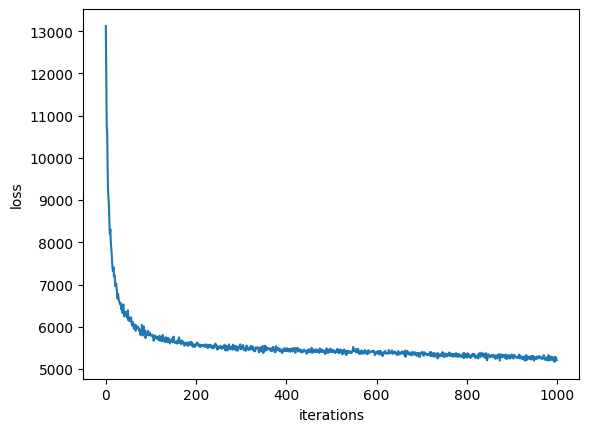

In [38]:
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("loss")

So now we have a decent latent factor representation of our users and our items. But we really care about the bundles, so we need to use these to get compatibility estimates between users and bundles. Here's our user-bundle compatibility function:

$$
\hat{x}_{u, b} = \frac{1}{|B_b|} \sum_{i\in B_b} [\kappa\beta_i + (\mu P_u) \cdot (\omega Q_i)] + Cc_b + N_b
$$

Just like the last one, we got this from the paper where we got the data from. At a high level, this is average the compatibility between the user and each item in the bundle, and then adjusting for how diverse the bundle is and how big the bundle is. Here's the specifics:
* $\beta_i$ - from the previous latent factor gradient descent. These will not change in this step
* $P_u$ - from the previous latent factor gradient descent. These will not change in this step
* $Q_i$ - from the previous latent factor gradient descent. These will not change in this step
* $B_b$ - the set of items in this bundle
* $\mu, \omega$ - 5 by 5 matrices that can adjust the latent factors before we take the dot product
* $c_b$ - the mean pairwise correlation between latent factors of the bundle items. Measures how diverse the games in the bundle are
* N - vector with a value for each bundle size (from 1 up to the size of the largest bundle). Encodes bundle size information, probably will penalize bundles that are too large or too small
* $\kappa$, $C$ - scalars 

We now optimize this over the same $BPROpt$ objective function, but this time our parameters are different and our dataset is the bundles, not the items.

In [ ]:
def make_bundle_tensors(bundle_item_map):
    return {
        b: torch.tensor(list(items), dtype=torch.long)
        for b, items in bundle_item_map.items()
    }

def compatibility_bundle_optimized(theta, muP, omegaQ, B, N, kappa, C, bundle_items_t):
    B_vec, P, Q = theta
    def comp(user, bundle):
        items_tensor = bundle_items_t[bundle]

        # Extract item embeddings
        wQ = omegaQ[items_tensor]        # [n_items, dim]
        B_items = B_vec[items_tensor]    # [n_items]

        # First term
        term1 = kappa * B_items
        term2 = torch.sum(muP[user] * wQ, dim=1)

        total_sum = (term1 + term2).mean()

        # Correlation term
        num_items = len(items_tensor)
        if num_items > 1:
            Q_items = Q[items_tensor]
            Q_centered = Q_items - Q_items.mean(dim=1, keepdim=True)
            norms = torch.norm(Q_centered, dim=1) + 1e-8
            corr = (Q_centered @ Q_centered.T) / (norms[:,None] * norms[None,:])

            cb = corr[~torch.eye(num_items, dtype=torch.bool)].mean()
        else:
            cb = 0.0

        total_sum = total_sum + C * cb + N[num_items - 1]
        return total_sum

    return comp

def BPROpt_bundle(theta, mu, omega, N, kappa, C, D, lam, bundle_item_map):
    B, P, Q = theta

    # ----- PRECOMPUTATIONS (major speedups) -----
    muP = P @ mu.T                  # [num_users, dim]
    omegaQ = Q @ omega.T            # [num_items, dim]
    bundle_items_t = make_bundle_tensors(bundle_item_map)

    # Optimized compatibility function
    comp = compatibility_bundle_optimized(
        theta, muP, omegaQ, B, N, kappa, C, bundle_items_t
    )

    total = 0.0

    # Loop over training triples
    for row in D:
        user = row[0].long().item()
        pos = row[1].item()
        neg = row[2].item()

        diff = comp(user, pos) - comp(user, neg)
        total += torch.nn.functional.logsigmoid(diff)

    # Regularization
    reg = lam * (mu.pow(2).sum() + omega.pow(2).sum() +
                 N.pow(2).sum() + kappa.pow(2) + C.pow(2))

    return total - reg


In [59]:
mu = torch.randn(5, 5, requires_grad = True)
omega = torch.randn(5, 5, requires_grad = True)
N = torch.randn(max([len(x) for x in bundle_item_map.values()]), requires_grad = True)
kappa = torch.randn(1, requires_grad = True)
C = torch.randn(1, requires_grad = True)

optimizer = torch.optim.SGD([mu, omega, N, kappa, C], lr = 0.001)

D_bundle_shuffled = D_bundle.sample(D_bundle.shape[0])
D_bundle_training = D_bundle_shuffled.iloc[:D_bundle_shuffled.shape[0] * 9 // 10, :]
D_bundle_testing = D_bundle_shuffled.iloc[D_bundle_shuffled.shape[0] * 9 // 10:, :]

In [ ]:
num_epochs = 50

lam = 0.01
losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()

    D = D_bundle_training.sample(D_bundle_training.shape[0] // 100).to_numpy()
    D = torch.from_numpy(D).int()

    loss = -BPROpt_bundle(theta, mu, omega, N, kappa, C, D, lam, bundle_item_map)

    loss.backward()

    optimizer.step()

    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")

Epoch 0, Loss: 1091.5354
Epoch 10, Loss: 603.5412
Epoch 20, Loss: 584.3250
Epoch 30, Loss: 543.8879
Epoch 40, Loss: 542.4941


Text(0, 0.5, 'loss')

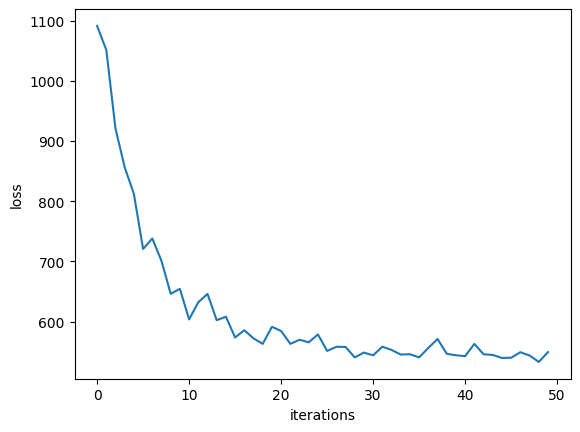

In [61]:
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("loss")

# SECTION 4
## Evaluation

Now that we have our somewhat-optimal parameters, we need to actually see how accurate our model is. This is where we use that test set that we set aside earlier. For each (user, bought-bundle, non-bought-bundle) triplet, we're hoping our model rates the compatibility of the bought-bundle higher. 


We chose to use an Area under ROC curve since we really care only about how well our model ranks the given bundles more so than directly if a user would buy a bundle or not. AUC captures this ranking ability directly by estimating the probability that a randomly chosen “positive” bundle (one the user interacted with) is scored higher than a randomly chosen “negative” one. It’s also insensitive to class imbalance, which is important because users interact with only a tiny fraction of all possible bundles in the actual implementation of this recommendation system. 

Let's see:

In [ ]:
def AUC_bundle(D_test, theta, mu, omega, N, kappa, C, bundle_item_map):
    B, P, Q = theta
    # ----- PRECOMPUTATIONS (major speedups) -----
    muP = P @ mu.T                  # [num_users, dim]
    omegaQ = Q @ omega.T            # [num_items, dim]
    bundle_items_t = make_bundle_tensors(bundle_item_map)
    comp = compatibility_bundle_optimized(theta, muP, omegaQ, B, N, kappa, C, bundle_items_t)

    counter = 0
    for u, pos, neg in D_test:
        diff = comp(u, pos) - comp(u, neg)
        if diff > 0:
            counter += 1

    return counter / D_test.shape[0]

AUC_bundle(D_bundle_testing.to_numpy().astype(int), theta, mu, omega, N, kappa, C, bundle_item_map)

0.5783944273152907

So our model performs moderately better than just randomly guessing. That's not bad considering we didn't do much hyperparameter tuning. I believe the paper uses 10 dimensional latent factors instead of 5, and they also use a separate lambda for each parameter. Our regularization is quite coarse.

A sensible baseline to compare this to would be some sort of item feature based model. In particular, we could do the following:
1. For each user, compile information about their recommended games. In particular, the genres, tags, and specs of all the games they've recommended (which is data we have access to through the reviews).
2. For each of the two bundles associated with the user in the data point (one positive and one negative), compute the Jaccard similarity between that user's data and the data of the games in the bundle. 
3. Predict that the user bought the bundle that has a higher similarity to the games they've recommended in the past

In [64]:
def readGz(path):
    for l in gzip.open(path, 'rt', encoding = 'utf8'):
        yield eval(l)

user_recommend = {}
dataset_folder_path = "dataset"

for  d in readGz(os.path.join(dataset_folder_path,"australian_user_reviews.json.gz")):
    user_recommend[d['user_id']] = [review["item_id"] for review in d['reviews'] if review["recommend"]==True]


steam_games_genres = {}
# collect all the genres, tags, specs info for each game

steam_games_genres = {}

missing_genres_count = 0
missing_tags_count = 0
missing_specs_count = 0
missing_id_count = 0
rep_items = 0

for d in readGz(os.path.join(dataset_folder_path,"steam_games.json.gz")):

    if 'id' not in d.keys():
        #print(f"This game has no id info!")
        #print(d)
        missing_id_count += 1
        continue

    if d['id'] in steam_games_genres.keys():
        #print(f"This game id ({d['id']}) already exists!")
        rep_items += 1
        continue

    if 'genres' not in d.keys():
        #print(f"This game id ({d['id']}) has no genre info!")
        genre_info = []
        missing_genres_count += 1

    else:
        genre_info = d['genres']

    if 'tags' not in d.keys():
        #print(f"This game id ({d['id']}) has no tag info!")
        tag_info = []
        missing_tags_count += 1

    else:
        tag_info = d['tags']

    if 'specs' not in d.keys():
        #print(f"This game id ({d['id']}) has no specs info!")
        specs_info = []
        missing_specs_count += 1

    else:
        specs_info = d['specs']

    steam_games_genres[d['id']] = {'genres': genre_info,
                                'tags': tag_info, 'specs': specs_info}

# collect the genre, tags, specs info of each game in each bundle
bundle_games_genres = {}

for d in readGz(os.path.join(dataset_folder_path,"bundle_data.json.gz")):

    if "bundle_id" not in d.keys() or "items" not in d.keys():
        #print(f"This bundle data is missing id or items info!")
        #print(d)
        continue

    games_ids = [g["item_id"] for g in d["items"]]

    bundle_games_genres[d["bundle_id"]] = {'genres': [], 'tags': [], 'specs': []}
    for item in games_ids:
        if item in steam_games_genres.keys():
            bundle_games_genres[d["bundle_id"]]['genres'].extend(steam_games_genres[item]['genres'])
            bundle_games_genres[d["bundle_id"]]['tags'].extend(steam_games_genres[item]['tags'])
            bundle_games_genres[d["bundle_id"]]['specs'].extend(steam_games_genres[item]['specs'])

    bundle_games_genres[d["bundle_id"]]['genres'] = list(set(bundle_games_genres[d["bundle_id"]]['genres']))
    bundle_games_genres[d["bundle_id"]]['tags'] = list(set(bundle_games_genres[d["bundle_id"]]['tags']))
    bundle_games_genres[d["bundle_id"]]['specs'] = list(set(bundle_games_genres[d["bundle_id"]]['specs']))

# for each user, collect all the genres, tags, specs info from the games they recommended

user_recommend_genres = {}
for user in user_recommend.keys():
    user_recommend_genres[user] = {'genres': [], 'tags': [], 'specs': []}
    for item in user_recommend[user]:
        if item in steam_games_genres.keys():
            user_recommend_genres[user]['genres'].extend(steam_games_genres[item]['genres'])
            user_recommend_genres[user]['tags'].extend(steam_games_genres[item]['tags'])
            user_recommend_genres[user]['specs'].extend(steam_games_genres[item]['specs'])


In [ ]:
tups = []
for i in range(D_bundle_testing.shape[0]):
    tups.append(
        (user_id_lookup[D_bundle_testing.iloc[i,0]],
         D_bundle_testing.iloc[i,1],
         D_bundle_testing.iloc[i,2])
    )

def jaccard_similarity(list1, list2):
    # use with list of strings or numbers
    set1 = set(list1)
    set2 = set(list2)

    intersection = set1.intersection(set2)
    union = set1.union(set2)

    if not union:
        return 0.0   # avoid division by zero

    return len(intersection) / len(union)

correct = 0
real_correct = 0
real_guesses = 0
fake_correct = 0
fake_guesses = 0
true_random = 0
one_missing = 0
for tup in tups:
    user = str(tup[0])
    pos_bund = tup[1]
    neg_bund = tup[2]

    try:
        user_genres = user_recommend_genres[user]["genres"]
        user_tags = user_recommend_genres[user]["tags"]
        user_specs = user_recommend_genres[user]["specs"]
        user_info = True
    except:
        user_info = False

    try:
        pos_bund_genres = bundle_games_genres[str(pos_bund)]["genres"]
        pos_bund_tags = bundle_games_genres[str(pos_bund)]["tags"]
        pos_bund_specs = bundle_games_genres[str(pos_bund)]["specs"]
        pos_info = True
    except:
        pos_info = False

    try:
        neg_bund_genres = bundle_games_genres[str(neg_bund)]["genres"]
        neg_bund_tags = bundle_games_genres[str(neg_bund)]["tags"]
        neg_bund_specs = bundle_games_genres[str(neg_bund)]["specs"]
        neg_info = True
    except:
        neg_info = False

    if np.all([user_info, pos_info, neg_info]):
        pos_mean_jaccard = np.mean([
            jaccard_similarity(user_genres, pos_bund_genres),
            jaccard_similarity(user_tags, pos_bund_tags),
            jaccard_similarity(user_specs, pos_bund_specs)
        ])

        neg_mean_jaccard = np.mean([
            jaccard_similarity(user_genres, neg_bund_genres),
            jaccard_similarity(user_tags, neg_bund_tags),
            jaccard_similarity(user_specs, neg_bund_specs)
        ])

        if pos_mean_jaccard > neg_mean_jaccard:
            correct += 1
            real_correct += 1
        real_guesses += 1
    else:
        if not user_info or (not pos_info and not neg_info):
            if np.random.randn() < 0:
                correct += 1
                fake_correct += 1
            true_random += 1
        elif not pos_info and neg_info:
            one_missing += 1
        elif pos_info and not neg_info:
            one_missing += 1
            correct += 1
            fake_correct += 1
        fake_guesses += 1

acc = correct / len(tups)

In [69]:
acc

0.4918351033458947

We see that this method is really the same as just guessing randomly. In fact, since sometimes the item features are missing, I set it to randomly guess if the features are missing. It's even worse if you only include the times it had to make a real guess

In [71]:
real_correct / real_guesses

0.4635612321562735

# SECTION 5
## Related Work

In the paper we referenced, this data was used in essentially the same way as we described. The core modeling setup and the general training approach are nearly identical. The main differences lie in the level of rigor and refinement applied to their methodology. For example, they trained their model more extensively and were more principled in how they selected and tuned hyperparameters. Their implementation used 10-dimensional latent factors, introduced separate regularization terms for each parameter type, and incorporated a more sophisticated procedure for sampling negative bundles. These adjustments, while subtle in isolation, collectively result in a more robust training pipeline.

A similar strategy appeared in one of our earlier course assignments, specifically assignment 1, where we predicted whether users had read a particular book. However, that task was much simpler due to the uniform negative sampling scheme. Because negatives were drawn uniformly, a naive predictor based largely on book popularity could perform surprisingly well, making the problem less challenging than it initially appeared. Additionally, that assignment required implementing the gradient updates explicitly, which forced us to work through the underlying mathematics in detail. In contrast, our current project leveraged PyTorch’s automatic differentiation, removing the need to manually derive gradient expressions and enabling us to focus more on model design and experimentation rather than low-level calculations.

Our results do not match those reported in the related work. Their model achieves substantially stronger performance, reaching AUC values in the high 0.80s. In my view, this discrepancy is primarily attributable to the more rigorous training regimen employed in their study. Their careful hyperparameter tuning, more expressive regularization scheme, and improved negative sampling strategy likely contributed to the performance gains they observed. While our approach captures the structure of their method, the reduced training depth and simpler design choices naturally limit the performance ceiling of our model.

## References

[1](https://cseweb.ucsd.edu/~jmcauley/pdfs/icdm18.pdf) Wang-Cheng Kang and Julian McAuley.  
**Self-attentive Sequential Recommendation.**  
IEEE International Conference on Data Mining (ICDM), 2018.

[2](https://cseweb.ucsd.edu/~jmcauley/pdfs/recsys18b.pdf) Mengting Wan and Julian McAuley.  
**Item Recommendation on Monotonic Behavior Chains.**  
ACM Conference on Recommender Systems (RecSys), 2018.

[3](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir17.pdf) Apurva Pathak, Kshitiz Gupta, and Julian McAuley.  
**Generating and Personalizing Bundle Recommendations on Steam.**  
ACM SIGIR Conference on Research and Development in Information Retrieval, 2017.
